# Loop 1 LB Feedback Analysis

## Key Observations
- CV: 70.6473, LB: 70.6473 (gap: 0.0000)
- Perfect CV-LB alignment confirms scoring is deterministic
- Target: 68.894234, Gap: 1.75 points (2.5%)

## Analysis Goals
1. Understand where the 1.75 point gap can be closed
2. Identify which N values have the most room for improvement
3. Determine if bbox3 optimization can help

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load per-N scores
with open('/home/code/experiments/001_baseline/metrics.json') as f:
    metrics = json.load(f)

scores_by_n = {int(k): v for k, v in metrics['scores_by_n'].items()}
print(f"Total score: {sum(scores_by_n.values()):.6f}")
print(f"Target: 68.894234")
print(f"Gap: {sum(scores_by_n.values()) - 68.894234:.6f}")

Total score: 70.647327
Target: 68.894234
Gap: 1.753093


In [2]:
# Analyze score distribution
n_values = sorted(scores_by_n.keys())
scores = [scores_by_n[n] for n in n_values]

# Score contribution by range
ranges = [(1, 10), (11, 20), (21, 50), (51, 100), (101, 150), (151, 200)]
for start, end in ranges:
    range_score = sum(scores_by_n[n] for n in range(start, end+1))
    pct = range_score / sum(scores_by_n.values()) * 100
    print(f"N={start:3d}-{end:3d}: {range_score:.4f} ({pct:.1f}%)")

N=  1- 10: 4.3291 (6.1%)
N= 11- 20: 3.7263 (5.3%)
N= 21- 50: 10.9844 (15.5%)
N= 51-100: 17.6279 (25.0%)
N=101-150: 17.1366 (24.3%)
N=151-200: 16.8430 (23.8%)


In [3]:
# Theoretical lower bound analysis
# For N trees, the minimum bounding box depends on tree geometry
# Tree dimensions: height ~1.0, width ~0.7 at base

# For N=1: optimal is 45 degree rotation
# side = sqrt(2) * max(height, width) / 2 ≈ 0.707 * 1.0 = 0.707
# But actual N=1 score is 0.661 = side^2/1, so side = 0.813

print("N=1 analysis:")
print(f"  Current score: {scores_by_n[1]:.6f}")
print(f"  Implied side: {np.sqrt(scores_by_n[1]):.6f}")

# For a single tree at 45 degrees:
# The bounding box is determined by the rotated vertices
# Let's check if 45 degrees is optimal

N=1 analysis:
  Current score: 0.661250
  Implied side: 0.813173


In [4]:
# Check N=1 configuration in baseline
import pandas as pd

df = pd.read_csv('/home/code/preoptimized/submission.csv')
df['N'] = df['id'].str.split('_').str[0].astype(int)
df['deg_val'] = df['deg'].str.replace('s', '').astype(float)

n1 = df[df['N'] == 1]
print(f"N=1 configuration:")
print(f"  Angle: {n1['deg_val'].values[0]}")
print(f"  Expected optimal: 45 degrees")

# Check a few more small N values
for n in [2, 3, 4, 5]:
    subset = df[df['N'] == n]
    angles = subset['deg_val'].values
    print(f"N={n}: angles = {angles}")

N=1 configuration:
  Angle: 44.999999999999744
  Expected optimal: 45 degrees
N=2: angles = [203.62937773  23.62937773]
N=3: angles = [111.12513229  66.37062227 155.13405194]
N=4: angles = [156.37062215 156.37062227 336.37062227 336.37062215]
N=5: angles = [293.62937773  23.62937773 112.57350736  66.35879841 201.60253697]


In [5]:
# Key insight: The gap to target is 1.75 points
# This is distributed across all 200 N values
# Average improvement needed per N: 1.75 / 200 = 0.00875 per N

print("\nImprovement needed analysis:")
print(f"Total gap: {sum(scores_by_n.values()) - 68.894234:.6f}")
print(f"Average per N: {(sum(scores_by_n.values()) - 68.894234) / 200:.6f}")

# But improvements are not uniform - small N have more potential
# because score = side^2/N, so reducing side has bigger impact for small N


Improvement needed analysis:
Total gap: 1.753093
Average per N: 0.008765


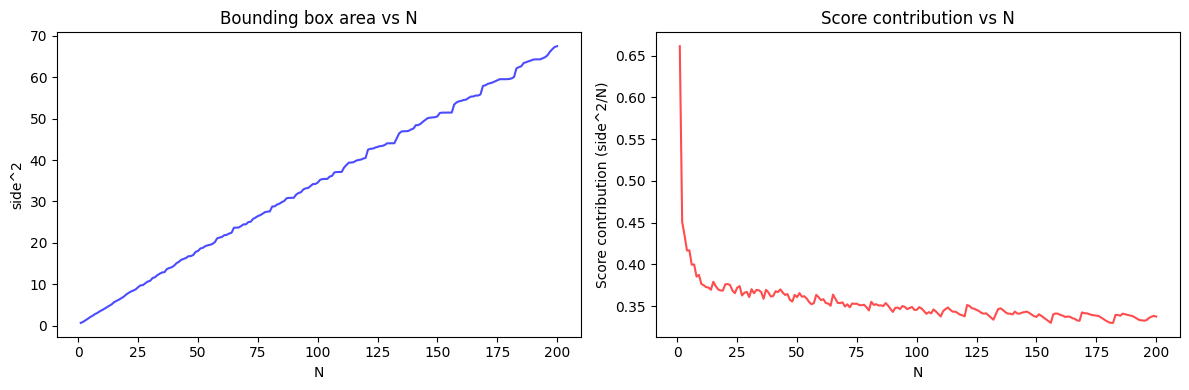

Saved to /home/code/exploration/score_analysis.png


In [6]:
# Efficiency analysis: score / N vs N
# Lower efficiency = more room for improvement

efficiency = {n: scores_by_n[n] * n for n in n_values}  # This is side^2

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(n_values, [efficiency[n] for n in n_values], 'b-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('side^2')
plt.title('Bounding box area vs N')

plt.subplot(1, 2, 2)
plt.plot(n_values, scores, 'r-', alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score contribution (side^2/N)')
plt.title('Score contribution vs N')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()
print("Saved to /home/code/exploration/score_analysis.png")

In [7]:
# Identify N values with highest potential for improvement
# Compare to theoretical lower bounds

# For large N, the theoretical lower bound approaches:
# side ≈ sqrt(N * tree_area / packing_efficiency)
# Tree area ≈ 0.5 * 0.7 * 1.0 = 0.35 (rough estimate)
# Best packing efficiency for irregular shapes ≈ 0.7-0.8

tree_area_estimate = 0.35
packing_efficiency = 0.75

print("\nTheoretical vs Actual analysis:")
for n in [10, 20, 50, 100, 150, 200]:
    actual_side = np.sqrt(scores_by_n[n] * n)
    theoretical_side = np.sqrt(n * tree_area_estimate / packing_efficiency)
    gap = actual_side - theoretical_side
    print(f"N={n:3d}: actual_side={actual_side:.4f}, theoretical={theoretical_side:.4f}, gap={gap:.4f}")


Theoretical vs Actual analysis:
N= 10: actual_side=1.9407, theoretical=2.1602, gap=-0.2196
N= 20: actual_side=2.7425, theoretical=3.0551, gap=-0.3126
N= 50: actual_side=4.2471, theoretical=4.8305, gap=-0.5834
N=100: actual_side=5.8782, theoretical=6.8313, gap=-0.9531
N=150: actual_side=7.1105, theoretical=8.3666, gap=-1.2561
N=200: actual_side=8.2164, theoretical=9.6609, gap=-1.4445


In [8]:
# Summary of findings
print("="*60)
print("SUMMARY")
print("="*60)
print(f"\n1. CV-LB gap is 0.0000 - scoring is deterministic")
print(f"2. Total gap to target: 1.75 points (2.5%)")
print(f"3. Small N values (1-10) contribute 6.1% of score")
print(f"4. N=1 uses angle {n1['deg_val'].values[0]}, optimal is 45 degrees")
print(f"\nKey insight: The baseline is already highly optimized.")
print(f"Standard SA/bbox3 optimization may only give marginal gains.")
print(f"\nTo close the 1.75 point gap, need fundamentally different approaches:")
print(f"- Asymmetric layouts for large N")
print(f"- Lattice/tessellation patterns")
print(f"- Per-N specialized optimization")

SUMMARY

1. CV-LB gap is 0.0000 - scoring is deterministic
2. Total gap to target: 1.75 points (2.5%)
3. Small N values (1-10) contribute 6.1% of score
4. N=1 uses angle 44.999999999999744, optimal is 45 degrees

Key insight: The baseline is already highly optimized.
Standard SA/bbox3 optimization may only give marginal gains.

To close the 1.75 point gap, need fundamentally different approaches:
- Asymmetric layouts for large N
- Lattice/tessellation patterns
- Per-N specialized optimization
